In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

sample_info = pd.read_csv('MOB_sample_info.csv', index_col=0)

df = pd.read_csv('data/Rep11_MOB_0.csv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

import NaiveDE

dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

Populating the interactive namespace from numpy and matplotlib


In [2]:
res.shape

(260, 14859)

In [3]:
results = pd.read_csv('MOB_final_results.csv', index_col=0)

results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

sres = results.query('qval < 0.05 & g != "log_total_count"').copy()

X = sample_info[['x', 'y']].values
Y = res[sres['g']].values.T

In [4]:
import GPy
import GPclust

In [5]:
np.random.seed(1)

m = GPclust.MOHGP(X=X,
                  Y=Y,
                  kernF=GPy.kern.RBF(2) + GPy.kern.Bias(2),
                  kernY=GPy.kern.RBF(1) + GPy.kern.White(1),
                  K=5,
                  prior_Z='DP')

m.hyperparam_opt_args['messages'] = False

# m.optimize(step_length=0.1, verbose=False)

In [6]:
m.optimize(step_length=0.1, verbose=False, maxiter=2000)

In [7]:
m

MOHGP.,value,constraints,priors
sum.rbf.variance,0.0762397706634,+ve,
sum.rbf.lengthscale,0.739164566834,+ve,
sum.bias.variance,20.4964389974,+ve,
sum_1.rbf.variance,4.26993666425,+ve,
sum_1.rbf.lengthscale,206.215863805,+ve,
sum_1.white.variance,0.139980042436,+ve,


In [8]:
m.phi_hat

array([ 11.00000091,   8.00015226,  19.00000004,  14.99999994,  13.99984685])

In [9]:
sres['cluster'] = m.phi_.argmax(1)
Cs = m.predict_components(X)

In [10]:
K_hat = len(sres.cluster.unique())
K_hat

5

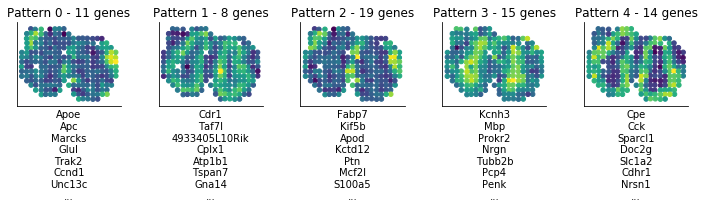

In [30]:
figsize(10, 3)
for i, Ci in enumerate(sres.sort_values('cluster').cluster.unique()):
    C = Cs[0][Ci]
    plt.subplot(1, K_hat, i + 1)
    plt.scatter(X[:,0], -X[:,1], c=C, s=20)
    plt.axis('equal')
    plt.title('Pattern {} - {} genes'.format(Ci, sres.query('cluster == @Ci').shape[0] ))
    
    xlab = '\n'.join(sres.query('cluster == @Ci').sort_values('pval')['g'].tolist()[:7])
    plt.xlabel(xlab + '\n...')
    
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.savefig('MOB_AEH.pdf', bbox_inches='tight')

In [16]:
for i in sres.sort_values('cluster').cluster.unique():
    
    print('Pattern {}'.format(i))
    print(', '.join(sres.query('cluster == @i').sort_values('pval')['g'].tolist()))
    print()

Pattern 0
Apoe, Apc, Marcks, Glul, Trak2, Ccnd1, Unc13c, Sepp1, Ptgds, Igf1, Sfrp5

Pattern 1
Cdr1, Taf7l, 4933405L10Rik, Cplx1, Atp1b1, Tspan7, Gna14, Olfr635

Pattern 2
Fabp7, Kif5b, Apod, Kctd12, Ptn, Mcf2l, S100a5, Omp, Scd1, Lpar1, Igfbp5, Nr2f2, Sash1, Frzb, Gng13, Sorbs1, Foxd3, Vtn, Pmepa1

Pattern 3
Kcnh3, Mbp, Prokr2, Nrgn, Tubb2b, Pcp4, Penk, Gpsm1, Pbx1, Baiap2, Rbfox3, Arhgap33, Camk2b, Necab2, Ncdn

Pattern 4
Cpe, Cck, Sparcl1, Doc2g, Slc1a2, Cdhr1, Nrsn1, Gabra1, Igfbp2, Slc6a11, Aqp4, Slc17a7, Rab3b, Trnp1

